In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Problem 1

In [2]:
# Download the data.
df = pd.read_csv('utah_air_2015.csv',skiprows=[1,2])
cols = list(df.columns)
cols[0] = 'Date'
df.columns = cols
print(df)

                  Date    BR    BV  ED    H3    HA    HC    HW    L4    LN  \
0        1/1/2015 0:00   2.2  22.6 NaN   NaN  26.8   4.8   NaN  19.2  23.9   
1        1/1/2015 1:00   3.9  18.7 NaN   NaN  31.7   4.7   NaN  22.7  28.1   
2        1/1/2015 2:00   3.2  14.1 NaN   NaN  29.8   4.9   NaN  23.9  25.8   
3        1/1/2015 3:00   2.4  12.8 NaN   NaN  23.3   7.0   NaN  29.5  17.6   
4        1/1/2015 4:00   1.4  14.0 NaN   NaN  24.9   3.8   NaN  17.3  14.4   
5        1/1/2015 5:00   1.4  14.2 NaN   NaN  22.5   3.8   NaN  12.0  14.1   
6        1/1/2015 6:00   0.9  15.0 NaN   NaN  19.6   4.1   NaN  11.0   9.0   
7        1/1/2015 7:00   0.6  17.8 NaN   NaN  21.5   4.0   NaN  11.1  12.4   
8        1/1/2015 8:00   4.2  14.6 NaN   NaN  21.1   4.9   NaN  11.1   9.9   
9        1/1/2015 9:00   1.7  17.9 NaN   NaN  18.5   5.1   NaN  11.9  11.9   
10      1/1/2015 10:00   6.1   5.8 NaN   NaN  15.1   4.0   NaN  10.9   8.7   
11      1/1/2015 11:00   6.8   3.4 NaN   NaN  12.9   4.1   NaN  

# Problem 2

In [3]:
# Clean up data--set negatives to zero.
data = df.filter(['Date','NP'])
data.describe()

,NP
count,8512.000000
mean,6.466612
std,6.612396
min,-10.000000
25%,2.800000
50%,5.000000
75%,8.100000
max,185.600000


In [4]:
data = data.fillna(0)
data[data['NP'] < 0] = 0
n = data.count(axis=0)['Date']
data.describe()

,NP
count,8760.000000
mean,6.374292
std,6.491120
min,0.000000
25%,2.700000
50%,4.900000
75%,7.900000
max,185.600000


# Problem 3

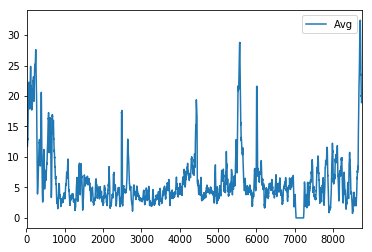

In [5]:
# Take moving average and plot.
mov_avg = pd.DataFrame(columns=['Avg'],index=data.index[12:-12])
for i in range(12,n-12) :
    mov_avg.iloc[i-12,0] = np.sum(data.iloc[i-11:i+11,1])/24 + (data.iloc[i-12,1]+data.iloc[i+12,1])/48
mov_avg.plot()
plt.show()

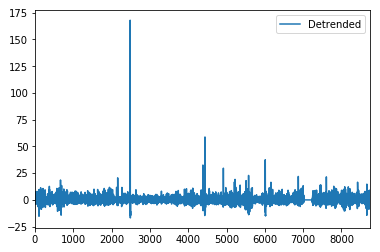

In [6]:
# Detrend original series
detrend_data = data.iloc[6:-6,1] - mov_avg.iloc[:,0]
detrend = pd.DataFrame(columns=['Detrended'],index=mov_avg.index,data=detrend_data)
detrend.plot()
plt.show()

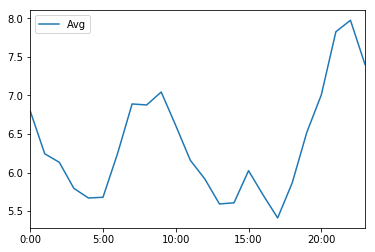

In [7]:
# Compute hour-of-the-day seasonal component
ks = np.arange(0,24,1)
hourly = pd.DataFrame(columns=['Avg'],index=[str(k)+':00' for k in ks])
for k in ks :
    vals = [data.iloc[k+24*i,1] for i in range(n//24)]
    avg = np.mean(vals)
    hourly.iloc[k,0] = avg
hourly.plot()
plt.show()

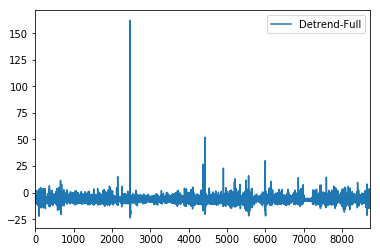

In [8]:
# Remove hourly seasonal component
hour_repeat = [hourly]*(8736//24)
cat_hourly = pd.concat(hour_repeat)
detrend = detrend.astype(float)
cat_hourly = cat_hourly.astype(float)
rem_hour_data = np.zeros(8736)
for i in range(8736) :
    rem_hour_data[i] = detrend.iloc[i,0] - cat_hourly.iloc[i,0]
rem_hour = pd.DataFrame(columns=['Detrend-Full'],data=rem_hour_data)
rem_hour.plot()
plt.show()

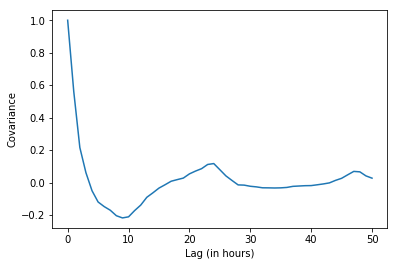

In [9]:
# Compute sample mean and autocovariance
μ = np.mean(rem_hour.iloc[:,0])
var = np.var(rem_hour.iloc[:,0])
n = rem_hour.count(axis=0)['Detrend-Full']
γ = []
ks = np.arange(0,51,1)
for k in ks :
    γ.append(np.sum([(rem_hour_data[i]-np.mean(rem_hour_data[i:n]))*(rem_hour_data[i-k]-np.mean(rem_hour_data[:(n-i)])) for i in range(k,n)])/(n-k))
ρ = [γ[i]/var for i in range(len(γ))]
# Plot autocorrelation.
plt.plot(ks,ρ)
plt.xlabel('Lag (in hours)')
plt.ylabel('Covariance')
plt.show()

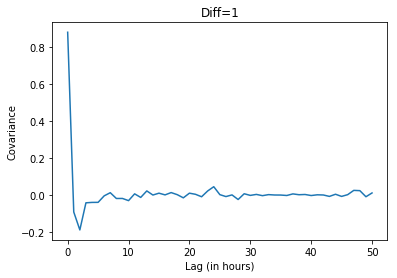

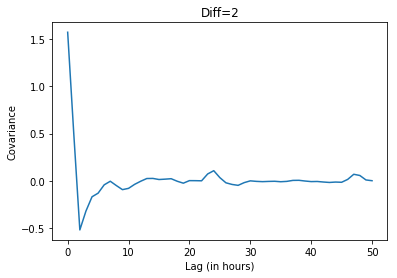

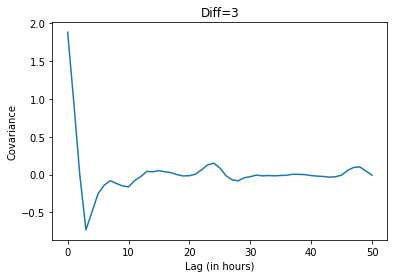

In [10]:
# Compute the j-th difference Δ_j x_t time series.
Δj = lambda x,j : x[j:] - x[:-j]
for j in [1,2,3] :
    diff = Δj(rem_hour_data,j)
    n = len(diff)
    γ = []
    for k in ks :
        γ.append(np.sum([(diff[i]-np.mean(diff[i:n]))*(diff[i-k]-np.mean(diff[:(n-i)])) for i in range(k,n)])/(n-k))
    ρ = [γ[i]/var for i in range(len(γ))]
    # Plot autocorrelation for each time series.
    plt.plot(ks,ρ)
    plt.title('Diff={}'.format(j))
    plt.xlabel('Lag (in hours)')
    plt.ylabel('Covariance')
    plt.show()

In [11]:
# Check to see if x_t is easily identifiable as an AR(2) model.
x = np.vstack((rem_hour_data[:-2],rem_hour_data[1:-1])).T
x = sm.add_constant(x)
y = rem_hour_data[2:]
results = sm.OLS(y,x).fit()
# Is R^2 close to 1?
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     2131.
Date:                Tue, 27 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:51:11   Log-Likelihood:                -22801.
No. Observations:                8734   AIC:                         4.561e+04
Df Residuals:                    8731   BIC:                         4.563e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0776      0.070    -43.854      0.0

In [20]:
# Repeat above step for Δ_j x_t for each j in {1, 2, 3}
def regress(x) :
    X = x[1:-1].T
    X = sm.add_constant(X)
    Y = x[2:]
    results = sm.OLS(Y,X).fit()
    print(results.summary())

In [21]:
for j in [1,2,3] :
    regress(Δj(rem_hour_data,j))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     100.8
Date:                Tue, 27 Mar 2018   Prob (F-statistic):           1.35e-23
Time:                        20:57:46   Log-Likelihood:                -23926.
No. Observations:                8733   AIC:                         4.786e+04
Df Residuals:                    8731   BIC:                         4.787e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.040      0.018      0.9